Application og Gaussian Process Regression to vertical profiles from scratch!

Ispiration from: https://github.com/peterroelants/peterroelants.github.io/tree/main/notebooks/gaussian_process

In [1]:
# imports
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy
import tqdm
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
import gruanpy as gp

In [2]:
# data
path = r'C:\Users\tomma\Documents\SDC\Repos\GRUAN_EDA\gdp\icm16\LIN-RS-01_2_RS41-GDP_001_20170303T120000_1-004-002.nc'
gdp = gp.read(path)
start = gdp.data['time'].values[0]
data=gdp.data[100:400]
time = data['time'].values
seconds = (time - start) / np.timedelta64(1, 's')
seconds = seconds.astype(float)
temp = data['temp'].values
temp_uc = data['temp_uc'].values
temp_variance = (temp_uc / 2)**2   # variance estimate

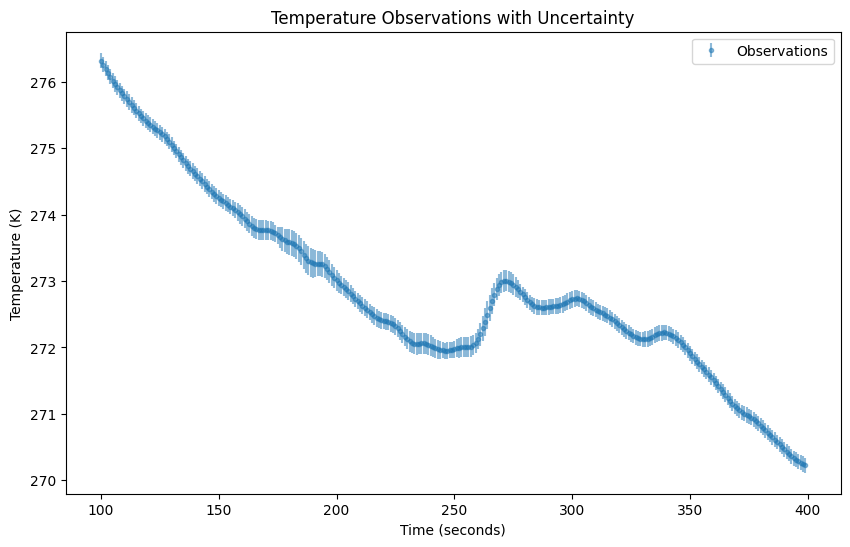

In [3]:
# plot original data with uncertainty
plt.figure(figsize=(10, 6))
plt.errorbar(seconds, temp, yerr=temp_uc, fmt='.', alpha=0.5, label='Observations', color='#1f77b4')
plt.xlabel('Time (seconds)')
plt.ylabel('Temperature (K)')
plt.title('Temperature Observations with Uncertainty')
plt.legend()
plt.show()

In [4]:
# kernel function
def exponential_kernel(x1, x2, length_scale, variance):
    """Exponential kernel function."""
    dists = np.abs(x1[:, None] - x2[None, :])
    return variance * np.exp(-dists / length_scale)

In [5]:
# a priori sampling
length_scale = 50.0  # length scale of the kernel
variance = 1.0       # variance of the kernel
K = exponential_kernel(seconds, seconds, length_scale, variance)
prior = K @ np.random.normal(size=(len(seconds), 3))

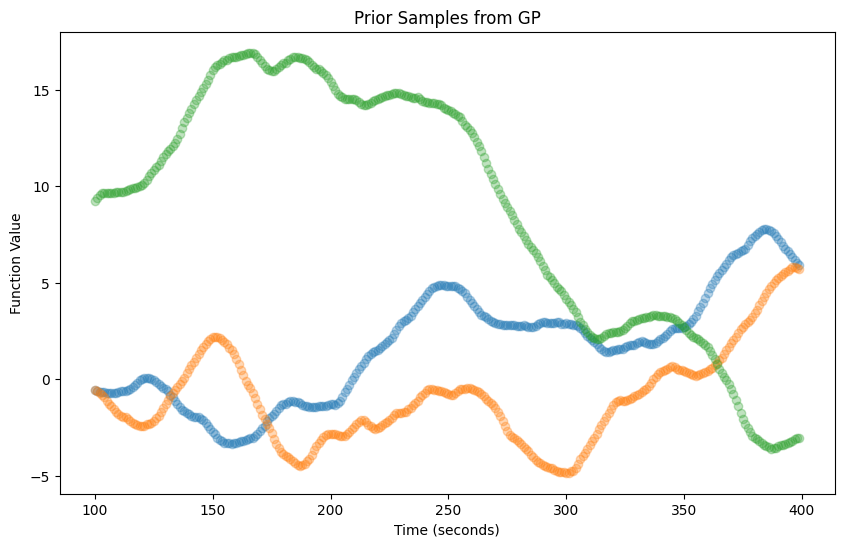

In [6]:
# plot prior samples
plt.figure(figsize=(10, 6))
for i in range(prior.shape[1]):
    plt.scatter(seconds, prior[:, i], alpha=0.3)
plt.title('Prior Samples from GP')
plt.xlabel('Time (seconds)')
plt.ylabel('Function Value')
plt.show()

C:\Users\tomma\AppData\Local\Temp\ipykernel_26380\1518312067.py:39: RuntimeWarning: invalid value encountered in sqrt
  std_post = np.sqrt(np.diag(cov_post))


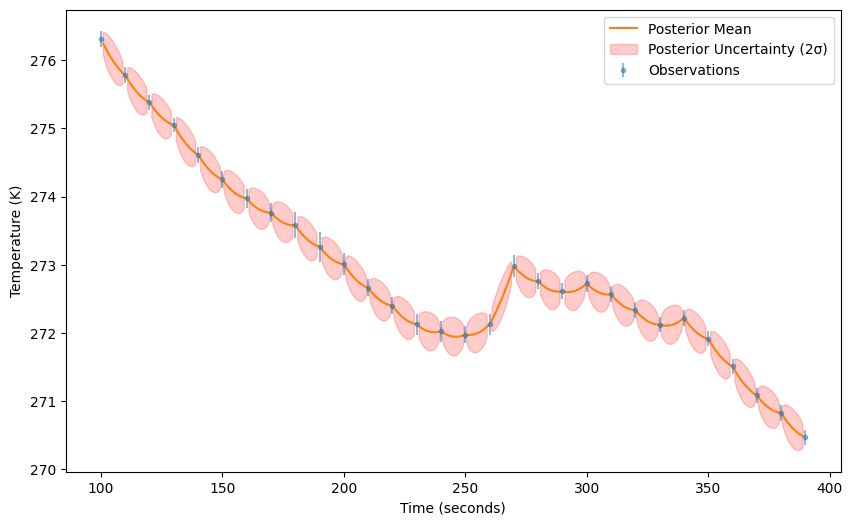

In [7]:
# posterior distribution
train_mask = range(0, len(seconds), 10)
test_mask = range(1, len(seconds)-10, 1)
train_seconds = seconds[train_mask]
train_temp = temp[train_mask]
train_variance = temp_variance[train_mask]
train_temp_uc = temp_uc[train_mask]
test_seconds = seconds[test_mask]
test_temp = temp[test_mask]
test_variance = temp_variance[test_mask]

def posterior_sampling(X1, y1, X2, kernel_func):
    """
    Calculate the posterior mean and covariance matrix for y2
    based on the corresponding input X2, the observations (y1, X1), 
    and the prior kernel function.
    """
    # Kernel of the observations
    Σ11 = kernel_func(X1, X1)
    # Kernel of observations vs to-predict
    Σ12 = kernel_func(X1, X2)
    # Solve
    solved = scipy.linalg.solve(Σ11, Σ12, assume_a='pos').T
    # Compute posterior mean
    μ2 = solved @ y1
    # Compute the posterior covariance
    Σ22 = kernel_func(X2, X2)
    Σ2 = Σ22 - (solved @ Σ12)
    return μ2, Σ2  # mean, covariance

mu_post, cov_post = posterior_sampling(
    train_seconds,
    train_temp,
    test_seconds,
    lambda x1, x2: exponential_kernel(x1, x2, 250, 1.0)
)

# plot mu_post and uncertainty
std_post = np.sqrt(np.diag(cov_post))
plt.figure(figsize=(10, 6))
plt.errorbar(train_seconds, train_temp, yerr=train_temp_uc, fmt='.', alpha=0.5, label='Observations', color='#1f77b4')
plt.plot(test_seconds, mu_post, label='Posterior Mean',  color='#ff7f0e')
plt.fill_between(test_seconds, mu_post - 2*std_post, mu_post + 2*std_post, color='red', alpha=0.2, label='Posterior Uncertainty (2σ)')
plt.xlabel('Time (seconds)')
plt.ylabel('Temperature (K)')
plt.legend()
plt.show()

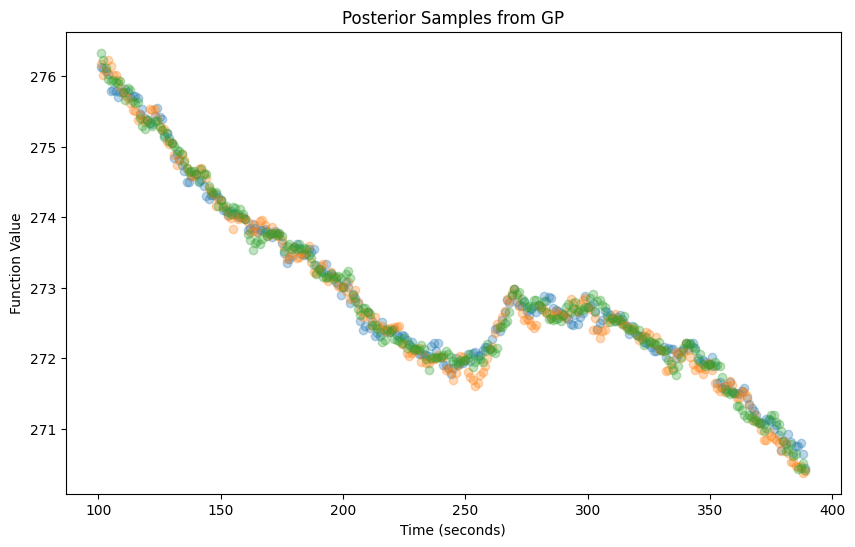

In [8]:
# posterior sampling
# Draw some samples of the posterior
y2 = np.random.multivariate_normal(mean=mu_post, cov=cov_post, size=3)
# plot posterior samples
plt.figure(figsize=(10, 6))
for i in range(y2.shape[0]):
    plt.scatter(test_seconds, y2[i, :], alpha=0.3)
plt.title('Posterior Samples from GP')
plt.xlabel('Time (seconds)')
plt.ylabel('Function Value')
plt.show()

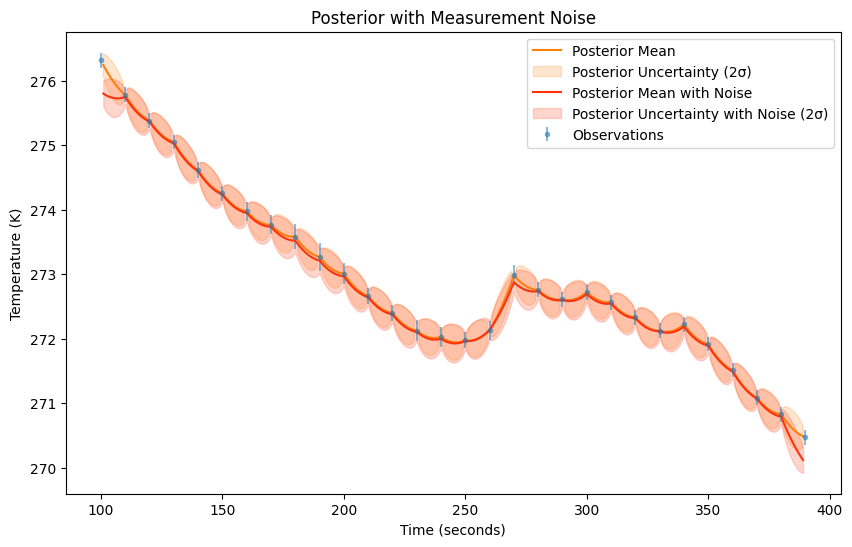

In [9]:
# add measurement error to posterior covariance

def posterior_sampling_with_noise(X1, y1, var1, X2, kernel_func):
    """
    Calculate the posterior mean and covariance matrix for y2
    based on the corresponding input X2, the observations (y1, X1), 
    observation variances var1, and the prior kernel function.
    """
    # Kernel of the observations
    Σ11 = kernel_func(X1, X1) + np.diag(var1)
    # Kernel of observations vs to-predict
    Σ12 = kernel_func(X1, X2)
    # Solve
    solved = scipy.linalg.solve(Σ11, Σ12, assume_a='pos').T
    # Compute posterior mean
    μ2 = solved @ y1
    # Compute the posterior covariance
    Σ22 = kernel_func(X2, X2)
    Σ2 = Σ22 - (solved @ Σ12)
    return μ2, Σ2  # mean, covariance

mu_post_noise, cov_post_noise = posterior_sampling_with_noise(
    train_seconds,
    train_temp,
    train_variance,
    test_seconds,
    lambda x1, x2: exponential_kernel(x1, x2, 250, 1.0)
)
# plot mu_post and uncertainty with noise
std_post_noise = np.sqrt(np.diag(cov_post_noise))
plt.figure(figsize=(10, 6))
plt.errorbar(train_seconds, train_temp, yerr=train_temp_uc, fmt='.', alpha=0.5, label='Observations', color='#1f77b4')
plt.plot(test_seconds, mu_post, label='Posterior Mean',  color='#ff7f0e')
plt.fill_between(test_seconds, mu_post - 2*std_post, mu_post + 2*std_post, color='#ff7f0e', alpha=0.2, label='Posterior Uncertainty (2σ)')
plt.plot(test_seconds, mu_post_noise, label='Posterior Mean with Noise',  color="#ff320e")
plt.fill_between(test_seconds, mu_post_noise - 2*std_post_noise, mu_post_noise + 2*std_post_noise, color='#ff320e', alpha=0.2, label='Posterior Uncertainty with Noise (2σ)')
plt.xlabel('Time (seconds)')
plt.ylabel('Temperature (K)')
plt.title('Posterior with Measurement Noise')
plt.legend()
plt.show()

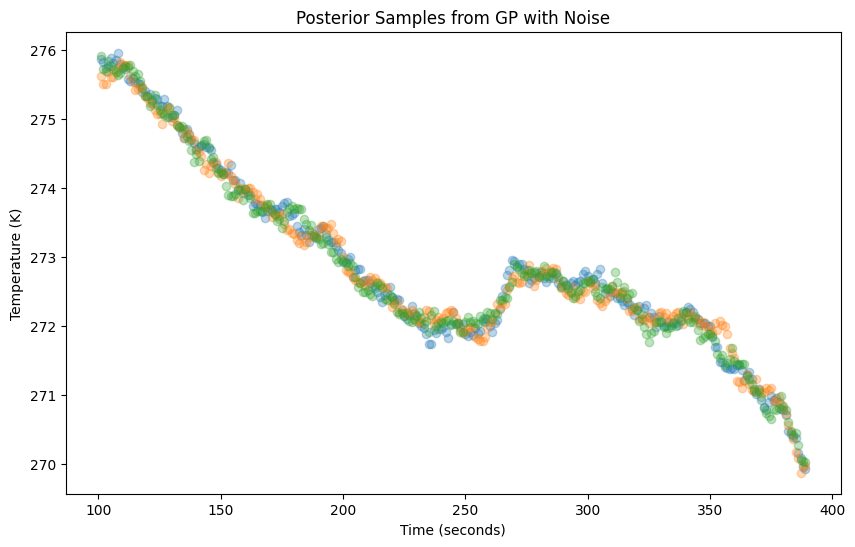

In [10]:
# posterior sampling with noise
y2_noise = np.random.multivariate_normal(mean=mu_post_noise, cov=cov_post_noise, size=3)
# plot posterior samples with noise
plt.figure(figsize=(10, 6))
for i in range(y2_noise.shape[0]):
    plt.scatter(test_seconds, y2_noise[i, :], alpha=0.3)
plt.title('Posterior Samples from GP with Noise')
plt.xlabel('Time (seconds)')
plt.ylabel('Temperature (K)')
plt.show()

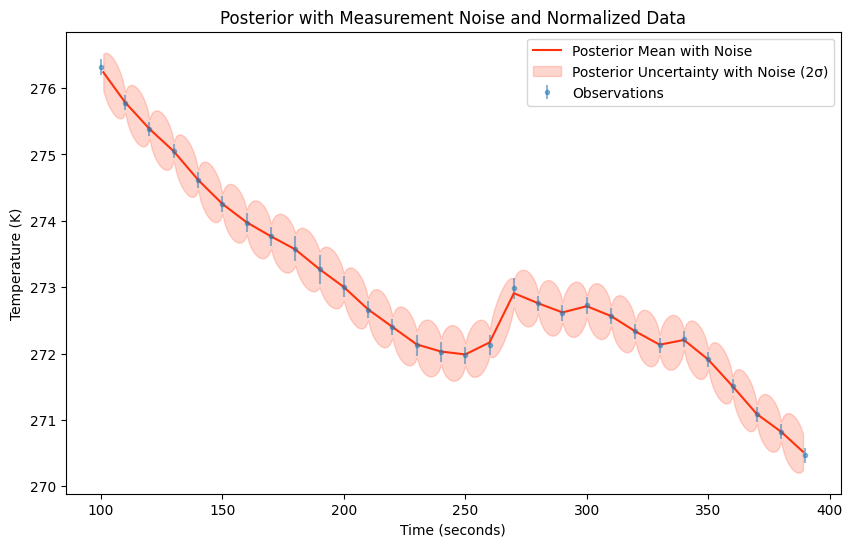

In [ ]:
# gp with measurement error and normalized data

avg_temp = np.mean(train_temp)
var_temp = np.var(train_temp)
norm_train_temp = (train_temp - avg_temp) / np.sqrt(var_temp)

mu_post_noise, cov_post_noise = posterior_sampling_with_noise(
    train_seconds,
    norm_train_temp,
    train_variance,
    test_seconds,
    lambda x1, x2: exponential_kernel(x1, x2, 250, 1.0)
)
mu_post_noise = mu_post_noise * np.sqrt(var_temp) + avg_temp
cov_post_noise = cov_post_noise * var_temp
# plot mu_post and uncertainty with noise
std_post_noise = np.sqrt(np.diag(cov_post_noise))
plt.figure(figsize=(10, 6))
plt.errorbar(train_seconds, train_temp, yerr=train_temp_uc, fmt='.', alpha=0.5, label='Observations', color='#1f77b4')
plt.plot(test_seconds, mu_post_noise, label='Posterior Mean with Noise',  color="#ff320e")
plt.fill_between(test_seconds, mu_post_noise - 2*std_post_noise, mu_post_noise + 2*std_post_noise, color='#ff320e', alpha=0.2, label='Posterior Uncertainty with Noise (2σ)')
plt.xlabel('Time (seconds)')
plt.ylabel('Temperature (K)')
plt.title('Posterior with Measurement Noise and Normalized Data')
plt.legend()
plt.show()

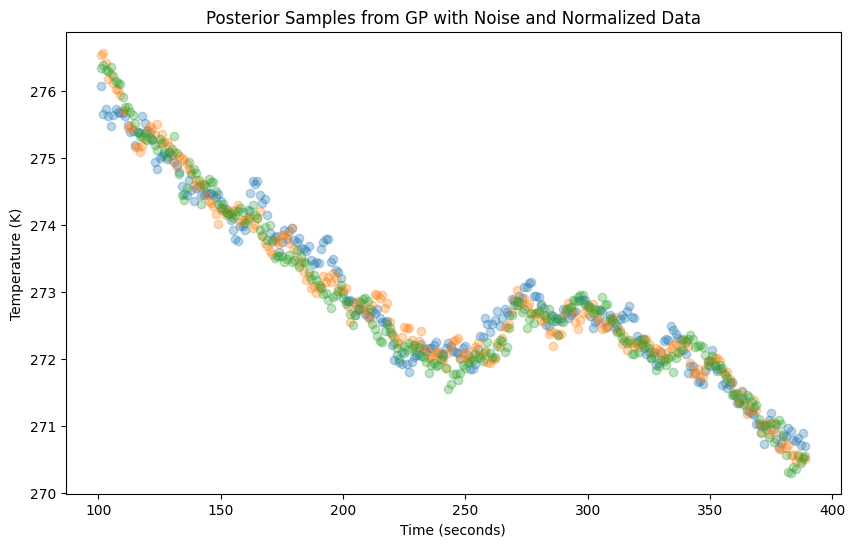

In [12]:
# posterior sampling with noise
y2_noise = np.random.multivariate_normal(mean=mu_post_noise, cov=cov_post_noise, size=3)
# plot posterior samples with noise
plt.figure(figsize=(10, 6))
for i in range(y2_noise.shape[0]):
    plt.scatter(test_seconds, y2_noise[i, :], alpha=0.3)
plt.title('Posterior Samples from GP with Noise and Normalized Data')
plt.xlabel('Time (seconds)')
plt.ylabel('Temperature (K)')
plt.show()

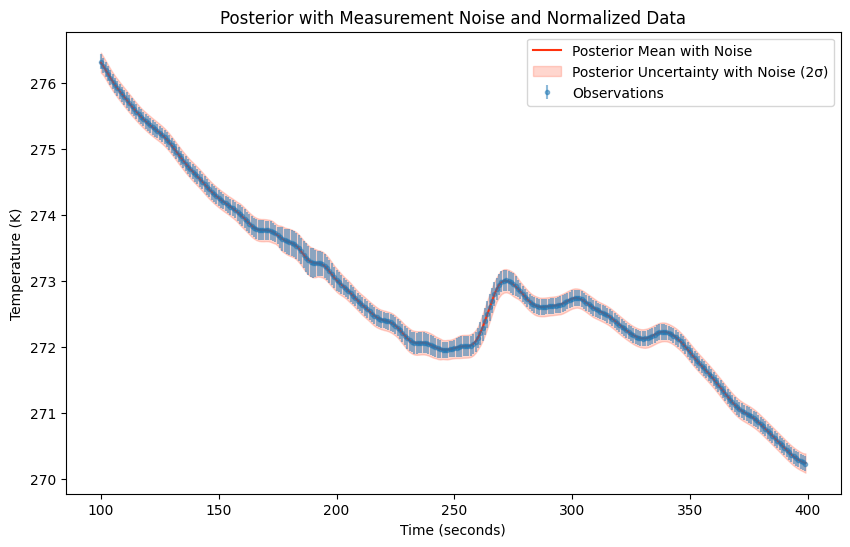

In [19]:
# gp with measurement error and normalized data

avg_temp = np.mean(temp)
var_temp = np.var(temp)
norm_train_temp = (temp - avg_temp) / np.sqrt(var_temp)

mu_post_noise, cov_post_noise = posterior_sampling_with_noise(
    seconds,
    norm_train_temp,
    temp_variance,
    seconds,
    lambda x1, x2: exponential_kernel(x1, x2, 100, 1.0)
)
mu_post_noise = mu_post_noise * np.sqrt(var_temp) + avg_temp
cov_post_noise = cov_post_noise * var_temp
# plot mu_post and uncertainty with noise
std_post_noise = np.sqrt(np.diag(cov_post_noise))
plt.figure(figsize=(10, 6))
plt.errorbar(seconds, temp, yerr=(temp_variance**0.5)*2, fmt='.', alpha=0.5, label='Observations', color='#1f77b4')
plt.plot(seconds, mu_post_noise, label='Posterior Mean with Noise',  color="#ff320e")
plt.fill_between(seconds, mu_post_noise - 2*std_post_noise, mu_post_noise + 2*std_post_noise, color='#ff320e', alpha=0.2, label='Posterior Uncertainty with Noise (2σ)')
plt.xlabel('Time (seconds)')
plt.ylabel('Temperature (K)')
plt.title('Posterior with Measurement Noise and Normalized Data')
plt.legend()
plt.show()

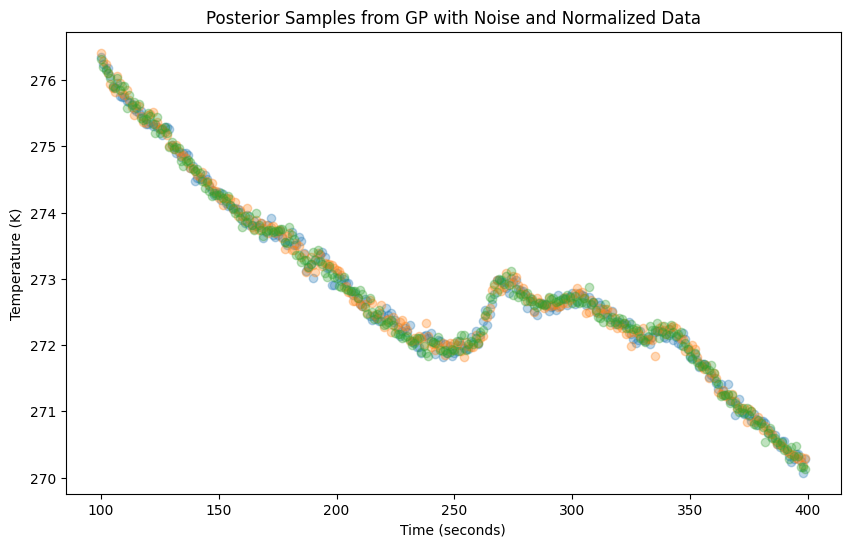

In [21]:
# posterior sampling with noise
y2_noise = np.random.multivariate_normal(mean=mu_post_noise, cov=cov_post_noise, size=3)
# plot posterior samples with noise
plt.figure(figsize=(10, 6))
for i in range(y2_noise.shape[0]):
    plt.scatter(seconds, y2_noise[i, :], alpha=0.3)
plt.title('Posterior Samples from GP with Noise and Normalized Data')
plt.xlabel('Time (seconds)')
plt.ylabel('Temperature (K)')
plt.show()